In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/eff-btrfly

/content/drive/MyDrive/Colab Notebooks/eff-btrfly


In [3]:
#arsitektur BtrflyNet
from btrfly import BtrflyNet

In [4]:
def posterior_prs(pos):
    tmp = pos.argmax(axis=1)
    for i in range(7, 13):
        tmp = tmp.where(tmp != i, torch.tensor(i-1))
    return tmp

In [5]:
#coba pakai loss function lainnya (?)

import torch
import torch.nn.functional as func

def compute_loss(gt_ant, gt_pos, out_ant, out_pos):

    loss_ant = func.cross_entropy(out_ant, gt_ant.argmax(axis=1))
    loss_pos = func.cross_entropy(out_pos, gt_pos.argmax(axis=1))

    return loss_ant + loss_pos


In [ ]:
#coba pakai loss function lainnya (?) --> ternyata hasilnya tidak lebih baik
"""
import torch
import torch.nn.functional as func

def compute_loss(gt_ant, gt_pos, out_ant, out_pos):

    loss_ant = func.nll_loss(out_ant, gt_ant.argmax(axis=1))
    loss_pos = func.nll_loss(out_pos, gt_pos.argmax(axis=1))

    return loss_ant + loss_pos
    

In [6]:
import matplotlib.pyplot as plt
import numpy as np

imsize = (512, 128, 1)

def masking(msk):
    tmp = msk.round()
    return [(tmp == i).astype('float').tolist() for i in range(13)]

In [7]:
from PIL import Image
from torchvision import transforms

tfms = transforms.Compose([transforms.ToTensor()])

In [8]:
import os

X, y = [], []

for name in os.listdir(f'./data/img'):
    if name[-5] == '1':
        X.append([
            tfms(Image.open(f'./data/img/{name[:-5]}1.png')).tolist(),
            tfms(Image.open(f'./data/img/{name[:-5]}2.png')).tolist()
        ])
        y.append([
            masking(plt.imread(f'./data/msk/{name[:-5]}1.png')[...,0] * 12),
            masking(plt.imread(f'./data/msk/{name[:-5]}2.png')[...,0] * 12)
        ])

vl = [ 6, 29,  0, 22, 34, 30,  4, 31]
tr = [i for i in range(37) if i not in vl]

X_train, X_valid = torch.Tensor( [X[i] for i in tr] ), torch.Tensor( [X[j] for j in vl] )
y_train, y_valid = torch.Tensor( [y[i] for i in tr] ), torch.Tensor( [y[j] for j in vl] )

n_data_train, n_data_valid = len(X_train), len(X_valid)

In [9]:
device     = torch.device('cuda')
best_valid = np.inf

In [10]:
import pickle

model = BtrflyNet().to(device)

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true[:,:,1:,:,:].flatten()
    y_pred_f = y_pred[:,:,1:,:,:].flatten()
    union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
    if union == 0: return 1
    intersection = (y_true_f * y_pred_f).sum().item()
    return 2 * intersection / union

In [12]:
def masking_torch(msk):
    return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])

In [13]:
import torchvision.transforms as trans
import timeit

from tqdm.notebook import tqdm

epochs   = 300
inp_size = (1,  3, 512, 128)
out_size = (1, 13, 512, 128)
dsc_size = (1, 1, 13, 512, 128)

#lr awal = 0.001 (paper IJCI)
#ujicoba lr={0.0001, 0.01}
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #ujicoba
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_losses = []
valid_losses = []

start = timeit.default_timer()

for epoch in tqdm( range(epochs) ):
    
    model.train()

    total_loss_train = 0
    total_loss_valid = 0
    
    for i in range(n_data_train):

        model.zero_grad()
        
        x, y = X_train[i], y_train[i]

        if np.random.random() > 0.5:
            h_flip = trans.RandomHorizontalFlip(1)
            x, y = h_flip(x), h_flip(y)
            #rtt = trans.RandomRotation(degrees=(5,10)) #random rotation
            #x, y = rtt(x), rtt(y)
        
        out_ant, out_pos = model(
            x[0].reshape(inp_size).to(device),
            x[1].reshape(inp_size).to(device)
        )

        loss_train = compute_loss(
            y[0].reshape(out_size).to(device),
            y[1].reshape(out_size).to(device),
            out_ant, out_pos
        )
        
        total_loss_train += loss_train.item()
        
        loss_train.backward()

        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
    
        for i in range(n_data_valid):
            
            x, y = X_valid[i], y_valid[i]
            
            out_ant, out_pos = model(
                x[0].reshape(inp_size).to(device),
                x[1].reshape(inp_size).to(device)
            )

            tmp = torch.cat([
                masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
                masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
            ], axis=1)

            if i == 0: y_predv = tmp + 0
            else: y_predv = torch.cat([y_predv, tmp], axis=0)

            loss_valid = compute_loss(
                y[0].reshape(out_size).to(device),
                y[1].reshape(out_size).to(device),
                out_ant, out_pos
            )

            total_loss_valid += loss_valid.item()

        for i in range(n_data_train):
            
            x, y = X_train[i], y_train[i]
            
            out_ant, out_pos = model(
                x[0].reshape(inp_size).to(device),
                x[1].reshape(inp_size).to(device)
            )

            tmp = torch.cat([
                masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
                masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
            ], axis=1)

            if i == 0: y_predt = tmp + 0
            else: y_predt = torch.cat([y_predt, tmp], axis=0)

    train_losses.append(total_loss_train / n_data_train)
    valid_losses.append(total_loss_valid / n_data_valid)

    scheduler.step(valid_losses[epoch])
    
    #print(f'')
    #print(f'- tr loss = {train_losses[epoch]:.4f}')
    #print(f'- vl loss = {valid_losses[epoch]:.4f}')
    #print(f'- tr dice = {dice_coef(y_train, y_predt)}')
    #print(f'- vl dice = {dice_coef(y_valid, y_predv)}')

    if best_valid > valid_losses[epoch]:
        best_valid = valid_losses[epoch] + 0
        print(f'')
        print(f'- tr loss = {train_losses[epoch]:.4f}')
        print(f'- vl loss = {valid_losses[epoch]:.4f}')
        print(f'- tr dice = {dice_coef(y_train, y_predt)}')
        print(f'- vl dice = {dice_coef(y_valid, y_predv)}')
        torch.save(model.state_dict(), f'./kupu-model/model-btr0206a.pt')
        print('model saved')

stop = timeit.default_timer()

print('Time: ', stop - start)

#model-btr2.pt : 09052023

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-12-89ed43dc3f24>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])



- tr loss = 4.6238
- vl loss = 4.3182
- tr dice = 0.22203765111989832
- vl dice = 0.22190502900497439
model saved

- tr loss = 4.1769
- vl loss = 4.0656
- tr dice = 0.41436433808894707
- vl dice = 0.41720530538826894
model saved

- tr loss = 3.9806
- vl loss = 3.8628
- tr dice = 0.4773299285921803
- vl dice = 0.48339659853837114
model saved

- tr loss = 3.7592
- vl loss = 3.6915
- tr dice = 0.48851217451294354
- vl dice = 0.4930801871703924
model saved

- tr loss = 3.6672
- vl loss = 3.6586
- tr dice = 0.5172414063560064
- vl dice = 0.531998391413476
model saved

- tr loss = 3.6426
- vl loss = 3.6399
- tr dice = 0.5687729504651577
- vl dice = 0.571185144729656
model saved

- tr loss = 3.6247
- vl loss = 3.6169
- tr dice = 0.5789510856481499
- vl dice = 0.5916694578046918
model saved

- tr loss = 3.6116
- vl loss = 3.6110
- tr dice = 0.590358330945291
- vl dice = 0.5931651460178322
model saved

- tr loss = 3.6007
- vl loss = 3.6063
- tr dice = 0.5885356107688777
- vl dice = 0.589953628

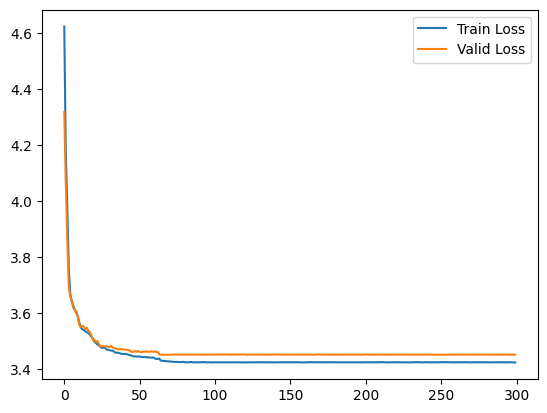

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [15]:
#09052023: loss-btr2.pickle
#
full_loss = (train_losses, valid_losses)
with open(f'./kupu-model/loss-btr0206a.pickle', 'wb') as f: pickle.dump(full_loss, f)